# CSIRO Image2Biomass Competition - Initial EDA

This notebook provides exploratory data analysis for the Image2Biomass Kaggle competition.

**Goal**: Predict 5 biomass measurements from pasture images:
- Dry_Clover_g (clover component)
- Dry_Dead_g (dead material)
- Dry_Green_g (green material)
- Dry_Total_g (total dry weight)
- GDM_g (green dry matter)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Base path
BASE_PATH = Path('/home/chaot/kaggle/Image2Biomass-Competition')

print('Libraries imported successfully! :D')

Libraries imported successfully! :D


## 1. Data Loading and Overview

In [2]:
# Load data
train_df = pd.read_csv(BASE_PATH / 'train.csv')
test_df = pd.read_csv(BASE_PATH / 'test.csv')
sample_sub = pd.read_csv(BASE_PATH / 'sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

Training data shape: (1785, 9)
Test data shape: (5, 3)
Sample submission shape: (5, 2)


In [3]:
# Display first few rows
print("\nFirst 10 rows of training data:")
train_df.head(10)


First 10 rows of training data:


sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   
5  ID1012260530__Dry_Clover_g  train/ID1012260530.jpg      2015/4/1   NSW   
6    ID1012260530__Dry_Dead_g  train/ID1012260530.jpg      2015/4/1   NSW   
7   ID1012260530__Dry_Green_g  train/ID1012260530.jpg      2015/4/1   NSW   
8   ID1012260530__Dry_Total_g  train/ID1012260530.jpg      2015/4/1   NSW   
9         ID1012260530__GDM_g  train/ID1012260530.jpg      2015/4/1   NSW   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750  
5          Lucerne           0.55        16.0000  Dry_Clover_g   0.0000  
6          Lucerne           0.55        16.0000    Dry_Dead_g   0.0000  
7          Lucerne           0.55        16.0000   Dry_Green_g   7.6000  
8          Lucerne           0.55        16.0000   Dry_Total_g   7.6000  
9          Lucerne           0.55        16.0000         GDM_g   7.6000

In [4]:
# Data info
print("\nTraining data info:")
print(train_df.info())
print("\nMissing values:")
print(train_df.isnull().sum())


Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
dtypes: float64(3), object(6)
memory usage: 125.6+ KB
None

Missing values:
sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64


In [5]:
# Extract image ID from sample_id
train_df['image_id'] = train_df['sample_id'].str.split('__').str[0]

# Count unique images
n_images = train_df['image_id'].nunique()
n_targets = train_df['target_name'].nunique()

print(f"\nNumber of unique images: {n_images}")
print(f"Number of target types: {n_targets}")
print(f"Total rows: {len(train_df)} ({n_images} images x {n_targets} targets)")


Number of unique images: 357
Number of target types: 5
Total rows: 1785 (357 images x 5 targets)


In [6]:
# Convert to wide format (1 row per image) for easier analysis
train_wide = train_df.pivot_table(
    index=['image_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'],
    columns='target_name',
    values='target'
).reset_index()

print(f"\nWide format shape: {train_wide.shape}")
train_wide.head()


Wide format shape: (357, 12)


target_name      image_id              image_path Sampling_Date State  \
0            ID1011485656  train/ID1011485656.jpg      2015/9/4   Tas   
1            ID1012260530  train/ID1012260530.jpg      2015/4/1   NSW   
2            ID1025234388  train/ID1025234388.jpg      2015/9/1    WA   
3            ID1028611175  train/ID1028611175.jpg     2015/5/18   Tas   
4            ID1035947949  train/ID1035947949.jpg     2015/9/11   Tas   

target_name            Species  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  \
0              Ryegrass_Clover           0.62         4.6667        0.0000   
1                      Lucerne           0.55        16.0000        0.0000   
2            SubcloverDalkeith           0.38         1.0000        6.0500   
3                     Ryegrass           0.66         5.0000        0.0000   
4                     Ryegrass           0.54         3.5000        0.4343   

target_name  Dry_Dead_g  Dry_Green_g  Dry_Total_g    GDM_g  
0               31.9984      16.2751      48.2735  16.2750  
1                0.0000       7.6000       7.6000   7.6000  
2                0.0000       0.0000       6.0500   6.0500  
3               30.9703      24.2376      55.2079  24.2376  
4               23.2239      10.5261      34.1844  10.9605

## 2. Target Variable Analysis

Let's examine the distribution of each target variable.

In [7]:
# Summary statistics for targets
target_cols = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']

print("Target variable statistics:")
train_wide[target_cols].describe().round(2)

Target variable statistics:


target_name  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  Dry_Total_g   GDM_g
count              357.00      357.00       357.00       357.00  357.00
mean                 6.65       12.04        26.62        45.32   33.27
std                 12.12       12.40        25.40        27.98   24.94
min                  0.00        0.00         0.00         1.04    1.04
25%                  0.00        3.20         8.80        25.27   16.03
50%                  1.42        7.98        20.80        40.30   27.11
75%                  7.24       17.64        35.08        57.88   43.68
max                 71.79       83.84       157.98       185.70  157.98

In [8]:
# Check frequency of zero values
print("\nZero value frequencies:")
for col in target_cols:
    zero_count = (train_wide[col] == 0).sum()
    zero_pct = (zero_count / len(train_wide)) * 100
    non_zero_mean = train_wide[train_wide[col] > 0][col].mean()
    print(f"{col:20s}: {zero_count:3d} zeros ({zero_pct:5.1f}%) | Non-zero mean: {non_zero_mean:6.2f}g")


Zero value frequencies:
Dry_Clover_g        : 135 zeros ( 37.8%) | Non-zero mean:  10.69g
Dry_Dead_g          :  40 zeros ( 11.2%) | Non-zero mean:  13.56g
Dry_Green_g         :  18 zeros (  5.0%) | Non-zero mean:  28.04g
Dry_Total_g         :   0 zeros (  0.0%) | Non-zero mean:  45.32g
GDM_g               :   0 zeros (  0.0%) | Non-zero mean:  33.27g


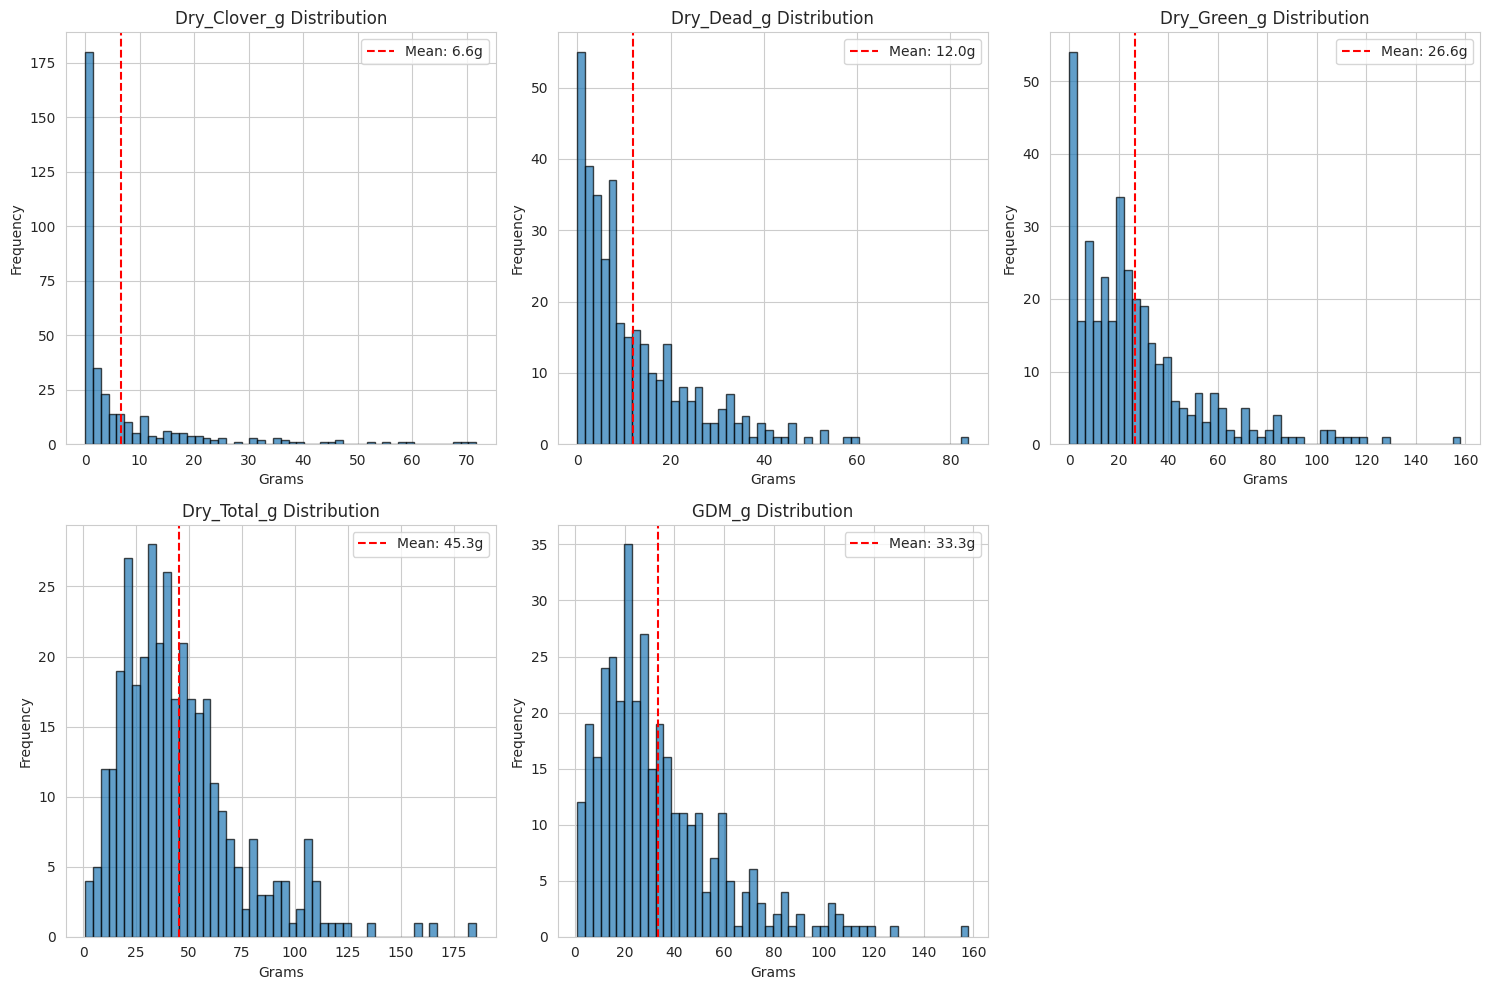

In [9]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    axes[i].hist(train_wide[col], bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel('Grams')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(train_wide[col].mean(), color='red', linestyle='--', label=f'Mean: {train_wide[col].mean():.1f}g')
    axes[i].legend()

axes[-1].axis('off')  # Hide last subplot
plt.tight_layout()
plt.show()

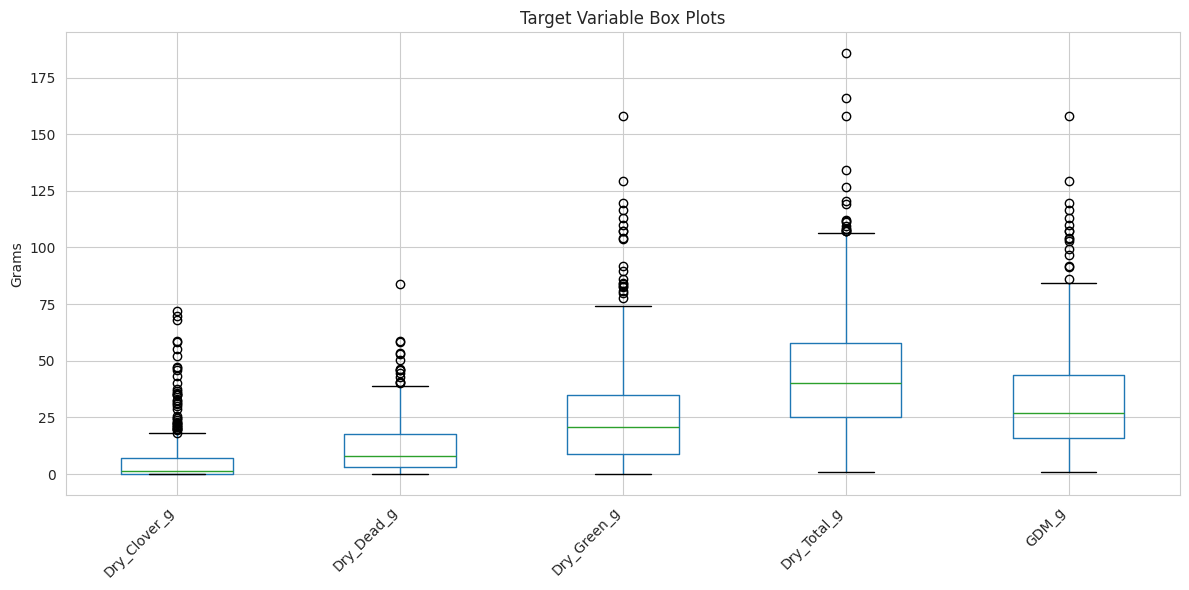

In [10]:
# Box plots
fig, ax = plt.subplots(figsize=(12, 6))
train_wide[target_cols].boxplot(ax=ax)
ax.set_title('Target Variable Box Plots')
ax.set_ylabel('Grams')
ax.set_xticklabels(target_cols, rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Target Relationships

The targets are biologically related. Let's examine their relationships.

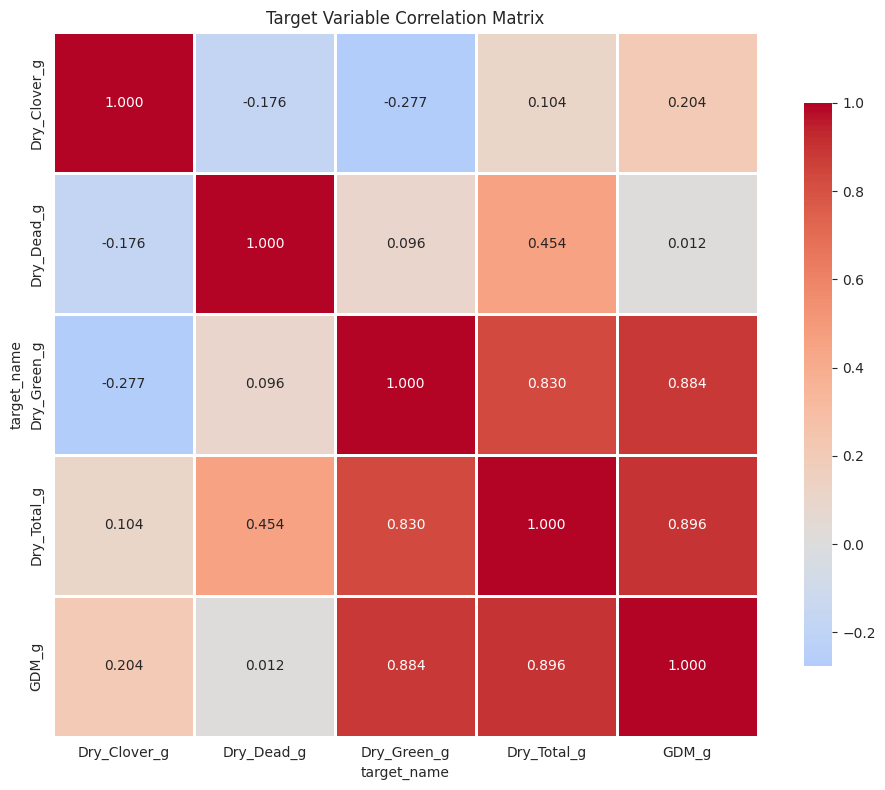

In [11]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = train_wide[target_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Target Variable Correlation Matrix')
plt.tight_layout()
plt.show()

In [12]:
# Validate constraint: Dry_Total = Dry_Clover + Dry_Dead + Dry_Green
train_wide['component_sum'] = (train_wide['Dry_Clover_g'] + 
                                train_wide['Dry_Dead_g'] + 
                                train_wide['Dry_Green_g'])

train_wide['total_diff'] = train_wide['Dry_Total_g'] - train_wide['component_sum']

print("\nValidating Dry_Total = Clover + Dead + Green:")
print(f"Mean difference: {train_wide['total_diff'].mean():.4f}g")
print(f"Max absolute difference: {train_wide['total_diff'].abs().max():.4f}g")
exact_matches = (train_wide['total_diff'].abs() < 0.01).sum()
print(f"Exact matches (within 0.01g): {exact_matches}/{len(train_wide)} ({exact_matches/len(train_wide)*100:.1f}%)")


Validating Dry_Total = Clover + Dead + Green:
Mean difference: -0.0009g
Max absolute difference: 0.3088g
Exact matches (within 0.01g): 356/357 (99.7%)


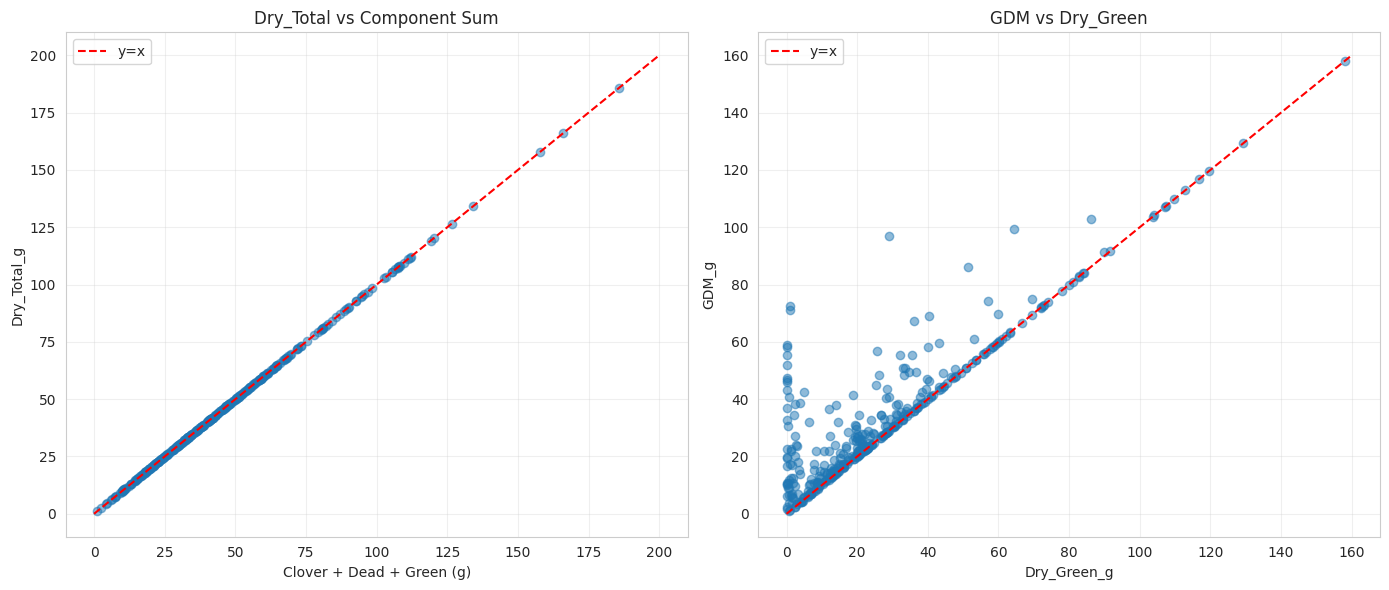

In [13]:
# Scatter: Dry_Total vs component sum
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Dry_Total vs sum
axes[0].scatter(train_wide['component_sum'], train_wide['Dry_Total_g'], alpha=0.5)
axes[0].plot([0, 200], [0, 200], 'r--', label='y=x')
axes[0].set_xlabel('Clover + Dead + Green (g)')
axes[0].set_ylabel('Dry_Total_g')
axes[0].set_title('Dry_Total vs Component Sum')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: GDM vs Dry_Green
axes[1].scatter(train_wide['Dry_Green_g'], train_wide['GDM_g'], alpha=0.5)
axes[1].plot([0, 160], [0, 160], 'r--', label='y=x')
axes[1].set_xlabel('Dry_Green_g')
axes[1].set_ylabel('GDM_g')
axes[1].set_title('GDM vs Dry_Green')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Analyze GDM_g vs Dry_Green_g relationship
gdm_green_equal = (train_wide['GDM_g'] == train_wide['Dry_Green_g']).sum()
print(f"\nGDM_g equals Dry_Green_g: {gdm_green_equal}/{len(train_wide)} ({gdm_green_equal/len(train_wide)*100:.1f}%)")
print(f"GDM_g > Dry_Green_g: {(train_wide['GDM_g'] > train_wide['Dry_Green_g']).sum()} cases")
print(f"GDM_g < Dry_Green_g: {(train_wide['GDM_g'] < train_wide['Dry_Green_g']).sum()} cases")


GDM_g equals Dry_Green_g: 127/357 (35.6%)
GDM_g > Dry_Green_g: 226 cases
GDM_g < Dry_Green_g: 4 cases


## 4. Metadata Feature Exploration

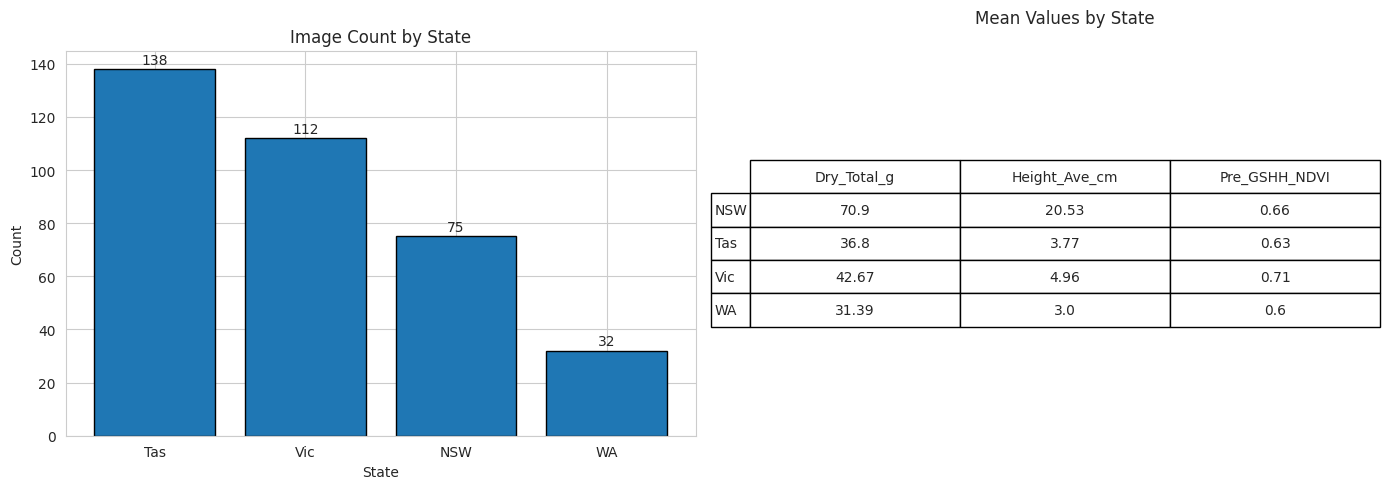

In [15]:
# State distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
state_counts = train_wide['State'].value_counts()
axes[0].bar(state_counts.index, state_counts.values, edgecolor='black')
axes[0].set_title('Image Count by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')
for i, v in enumerate(state_counts.values):
    axes[0].text(i, v + 2, str(v), ha='center')

# Statistics by state
state_stats = train_wide.groupby('State')[['Dry_Total_g', 'Height_Ave_cm', 'Pre_GSHH_NDVI']].mean().round(2)
axes[1].axis('off')
table = axes[1].table(cellText=state_stats.values, 
                      rowLabels=state_stats.index,
                      colLabels=state_stats.columns,
                      cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1].set_title('Mean Values by State', pad=20)

plt.tight_layout()
plt.show()

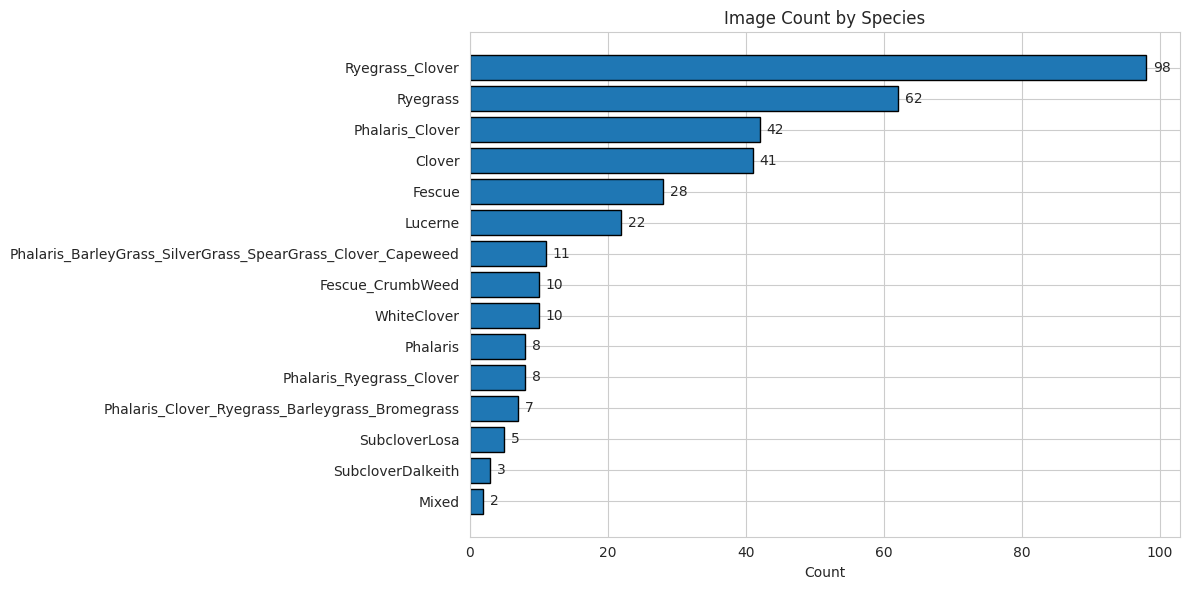

In [16]:
# Species distribution
species_counts = train_wide['Species'].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(species_counts)), species_counts.values, edgecolor='black')
ax.set_yticks(range(len(species_counts)))
ax.set_yticklabels(species_counts.index)
ax.set_xlabel('Count')
ax.set_title('Image Count by Species')
ax.invert_yaxis()
for i, v in enumerate(species_counts.values):
    ax.text(v + 1, i, str(v), va='center')

plt.tight_layout()
plt.show()

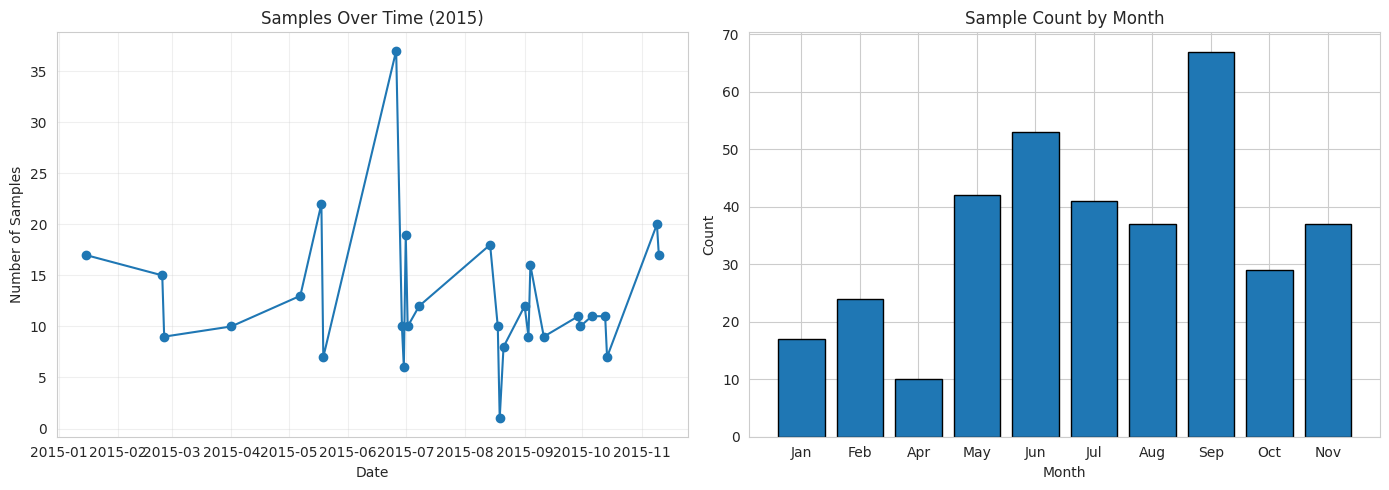

In [17]:
# Temporal distribution
train_wide['Sampling_Date'] = pd.to_datetime(train_wide['Sampling_Date'])
train_wide['Month'] = train_wide['Sampling_Date'].dt.month

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Samples over time
date_counts = train_wide['Sampling_Date'].value_counts().sort_index()
axes[0].plot(date_counts.index, date_counts.values, marker='o')
axes[0].set_title('Samples Over Time (2015)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Samples')
axes[0].grid(True, alpha=0.3)

# By month
month_counts = train_wide['Month'].value_counts().sort_index()
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
axes[1].bar(range(len(month_counts)), month_counts.values, edgecolor='black')
axes[1].set_xticks(range(len(month_counts)))
axes[1].set_xticklabels([month_names[i] for i in month_counts.index])
axes[1].set_title('Sample Count by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

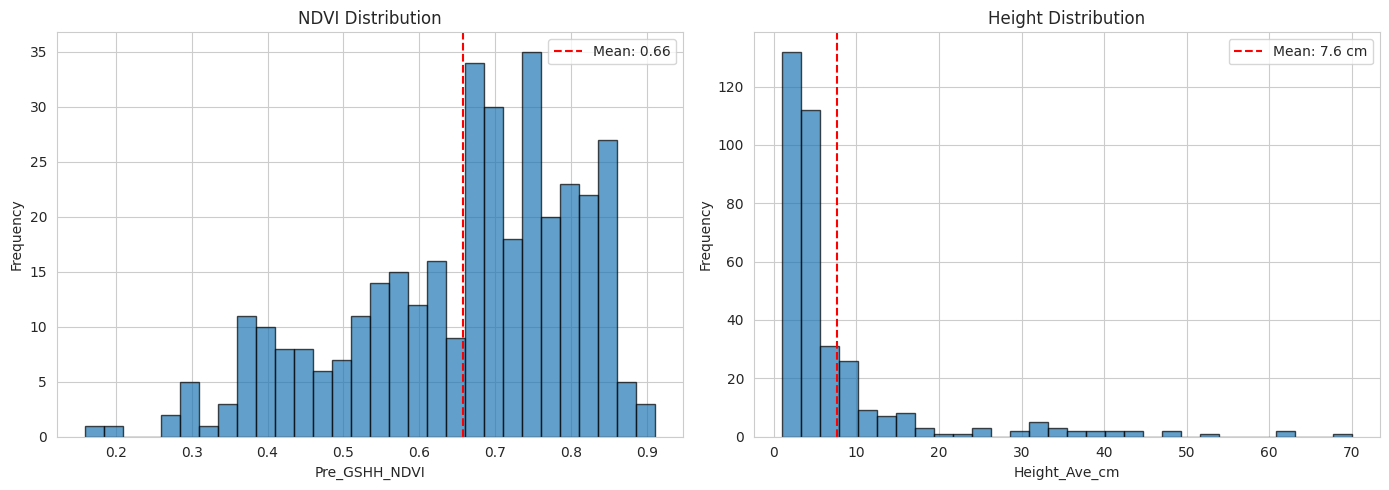

In [18]:
# NDVI and Height distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# NDVI
axes[0].hist(train_wide['Pre_GSHH_NDVI'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(train_wide['Pre_GSHH_NDVI'].mean(), color='red', linestyle='--', 
                label=f"Mean: {train_wide['Pre_GSHH_NDVI'].mean():.2f}")
axes[0].set_title('NDVI Distribution')
axes[0].set_xlabel('Pre_GSHH_NDVI')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Height
axes[1].hist(train_wide['Height_Ave_cm'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(train_wide['Height_Ave_cm'].mean(), color='red', linestyle='--',
                label=f"Mean: {train_wide['Height_Ave_cm'].mean():.1f} cm")
axes[1].set_title('Height Distribution')
axes[1].set_xlabel('Height_Ave_cm')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Feature vs Target Analysis

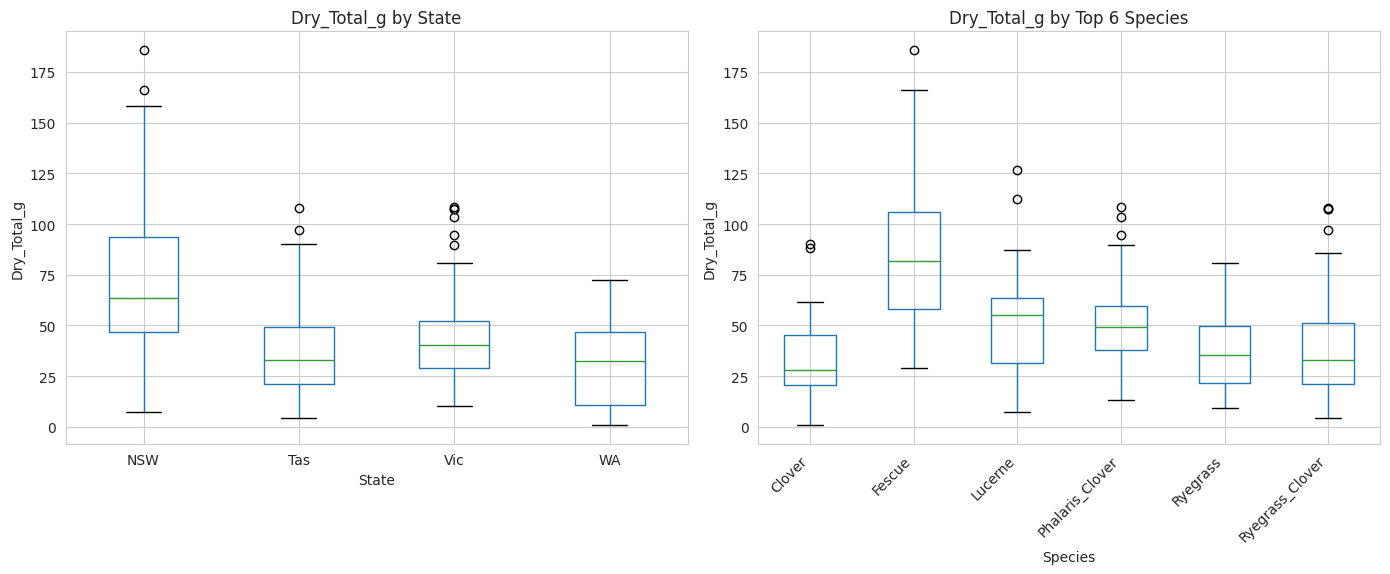

In [19]:
# Box plots: Dry_Total by State and Species
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# By State
train_wide.boxplot(column='Dry_Total_g', by='State', ax=axes[0])
axes[0].set_title('Dry_Total_g by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Dry_Total_g')
plt.sca(axes[0])
plt.xticks(rotation=0)

# By top 6 Species
top_species = train_wide['Species'].value_counts().head(6).index
train_wide[train_wide['Species'].isin(top_species)].boxplot(column='Dry_Total_g', by='Species', ax=axes[1])
axes[1].set_title('Dry_Total_g by Top 6 Species')
axes[1].set_xlabel('Species')
axes[1].set_ylabel('Dry_Total_g')
plt.sca(axes[1])
plt.xticks(rotation=45, ha='right')

plt.suptitle('')  # Remove auto title
plt.tight_layout()
plt.show()

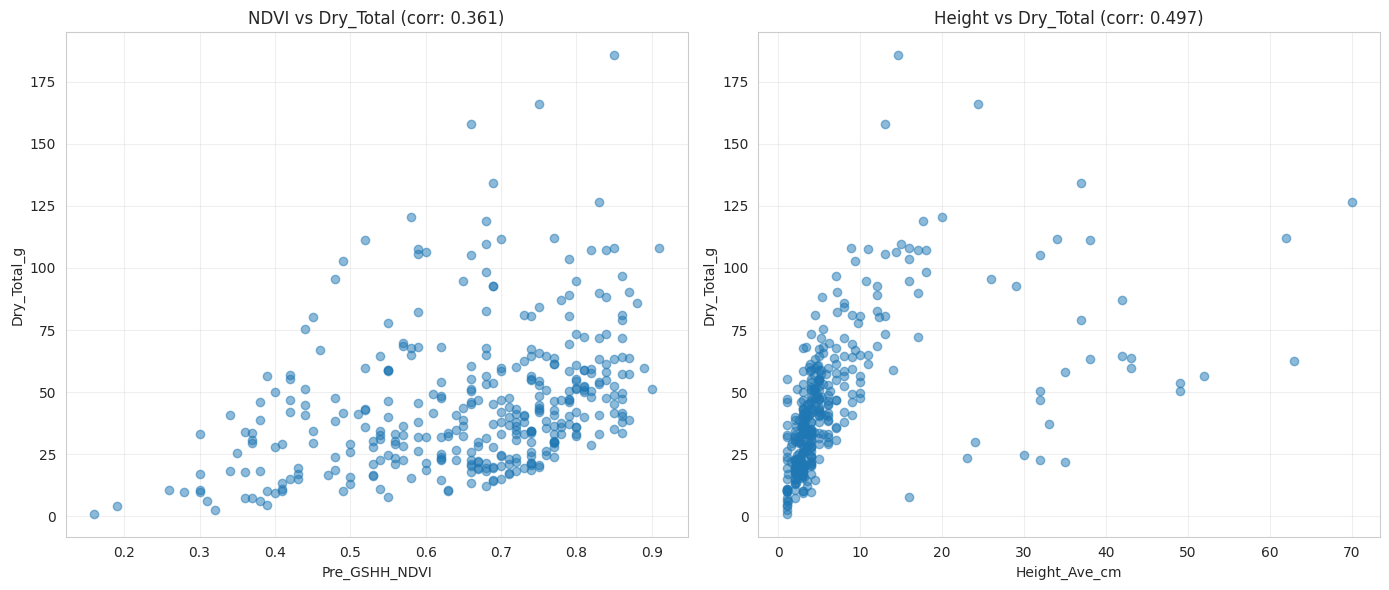

In [20]:
# Scatter plots: NDVI and Height vs Dry_Total
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# NDVI vs Dry_Total
axes[0].scatter(train_wide['Pre_GSHH_NDVI'], train_wide['Dry_Total_g'], alpha=0.5)
axes[0].set_xlabel('Pre_GSHH_NDVI')
axes[0].set_ylabel('Dry_Total_g')
axes[0].set_title(f"NDVI vs Dry_Total (corr: {train_wide[['Pre_GSHH_NDVI', 'Dry_Total_g']].corr().iloc[0,1]:.3f})")
axes[0].grid(True, alpha=0.3)

# Height vs Dry_Total
axes[1].scatter(train_wide['Height_Ave_cm'], train_wide['Dry_Total_g'], alpha=0.5)
axes[1].set_xlabel('Height_Ave_cm')
axes[1].set_ylabel('Dry_Total_g')
axes[1].set_title(f"Height vs Dry_Total (corr: {train_wide[['Height_Ave_cm', 'Dry_Total_g']].corr().iloc[0,1]:.3f})")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

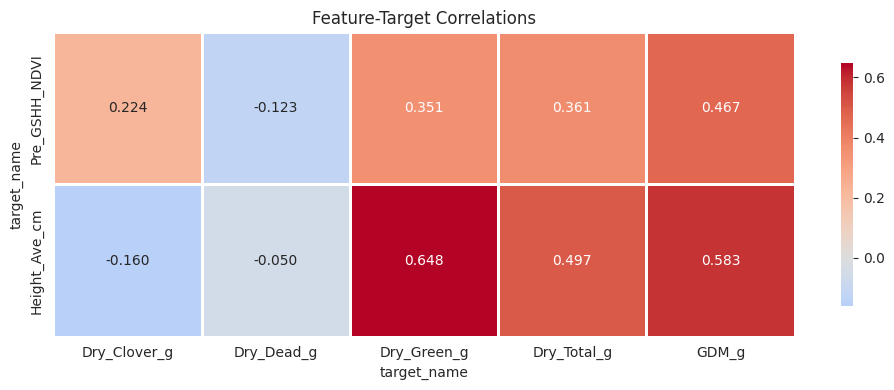

In [21]:
# Correlation coefficients: all features vs all targets
feature_cols = ['Pre_GSHH_NDVI', 'Height_Ave_cm']
corr_df = train_wide[feature_cols + target_cols].corr().loc[feature_cols, target_cols]

plt.figure(figsize=(10, 4))
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Feature-Target Correlations')
plt.tight_layout()
plt.show()

## 6. Image Exploration

Let's look at some sample images to understand visual characteristics.

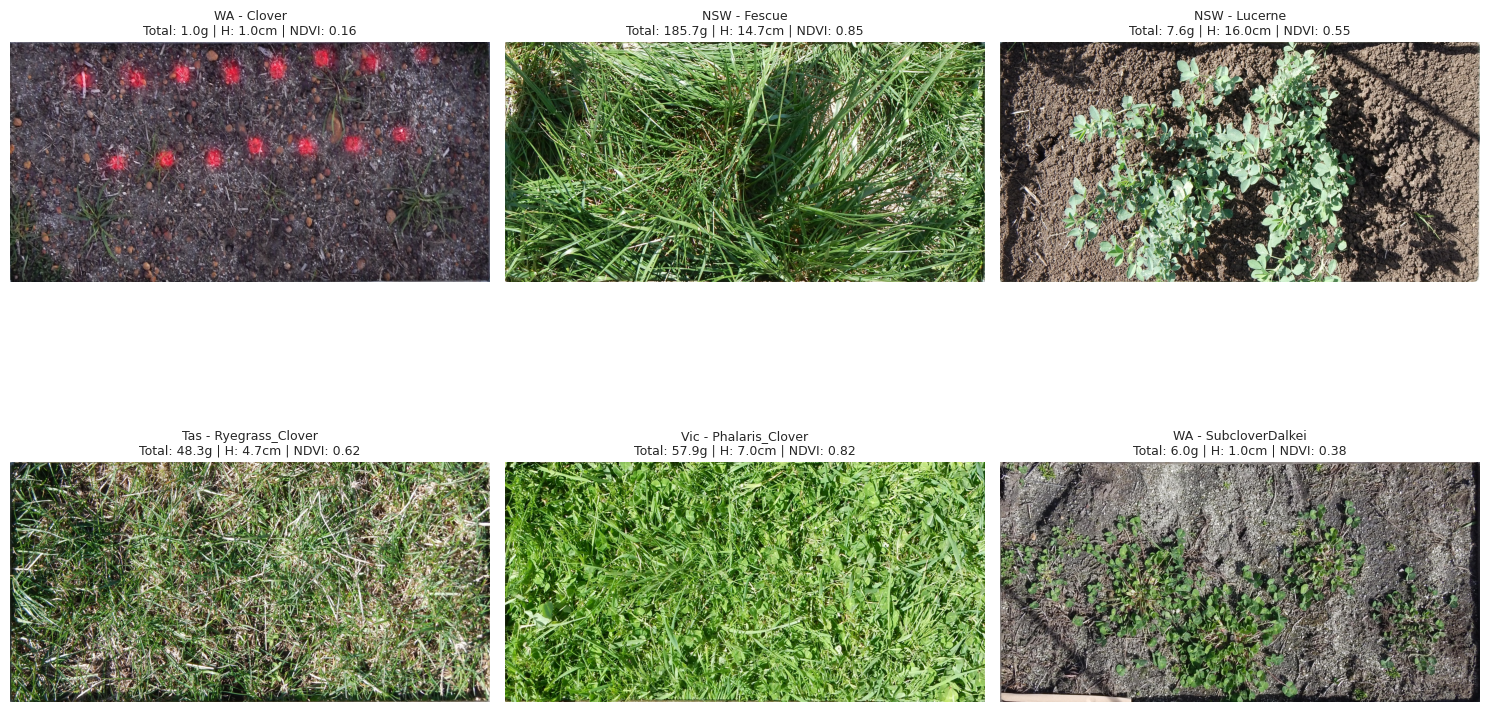

In [22]:
# Select diverse samples
sample_indices = [
    train_wide['Dry_Total_g'].idxmin(),  # Lowest biomass
    train_wide['Dry_Total_g'].idxmax(),  # Highest biomass
    train_wide[train_wide['State'] == 'NSW'].index[0],  # NSW
    train_wide[train_wide['State'] == 'Tas'].index[0],  # Tasmania
    train_wide[train_wide['State'] == 'Vic'].index[0],  # Victoria
    train_wide[train_wide['State'] == 'WA'].index[0],   # Western Australia
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    row = train_wide.iloc[idx]
    img_path = BASE_PATH / row['image_path']
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].axis('off')
    title = f"{row['State']} - {row['Species'][:15]}\n"
    title += f"Total: {row['Dry_Total_g']:.1f}g | H: {row['Height_Ave_cm']:.1f}cm | NDVI: {row['Pre_GSHH_NDVI']:.2f}"
    axes[i].set_title(title, fontsize=9)

plt.tight_layout()
plt.show()

In [23]:
# Check image dimensions
print("Checking image dimensions...")
sample_images = train_wide.sample(10)['image_path'].values
dimensions = []

for img_path in sample_images:
    img = Image.open(BASE_PATH / img_path)
    dimensions.append(img.size)

print(f"Sample image dimensions: {set(dimensions)}")
print(f"All images have same dimensions: {len(set(dimensions)) == 1}")

Checking image dimensions...
Sample image dimensions: {(2000, 1000)}
All images have same dimensions: True


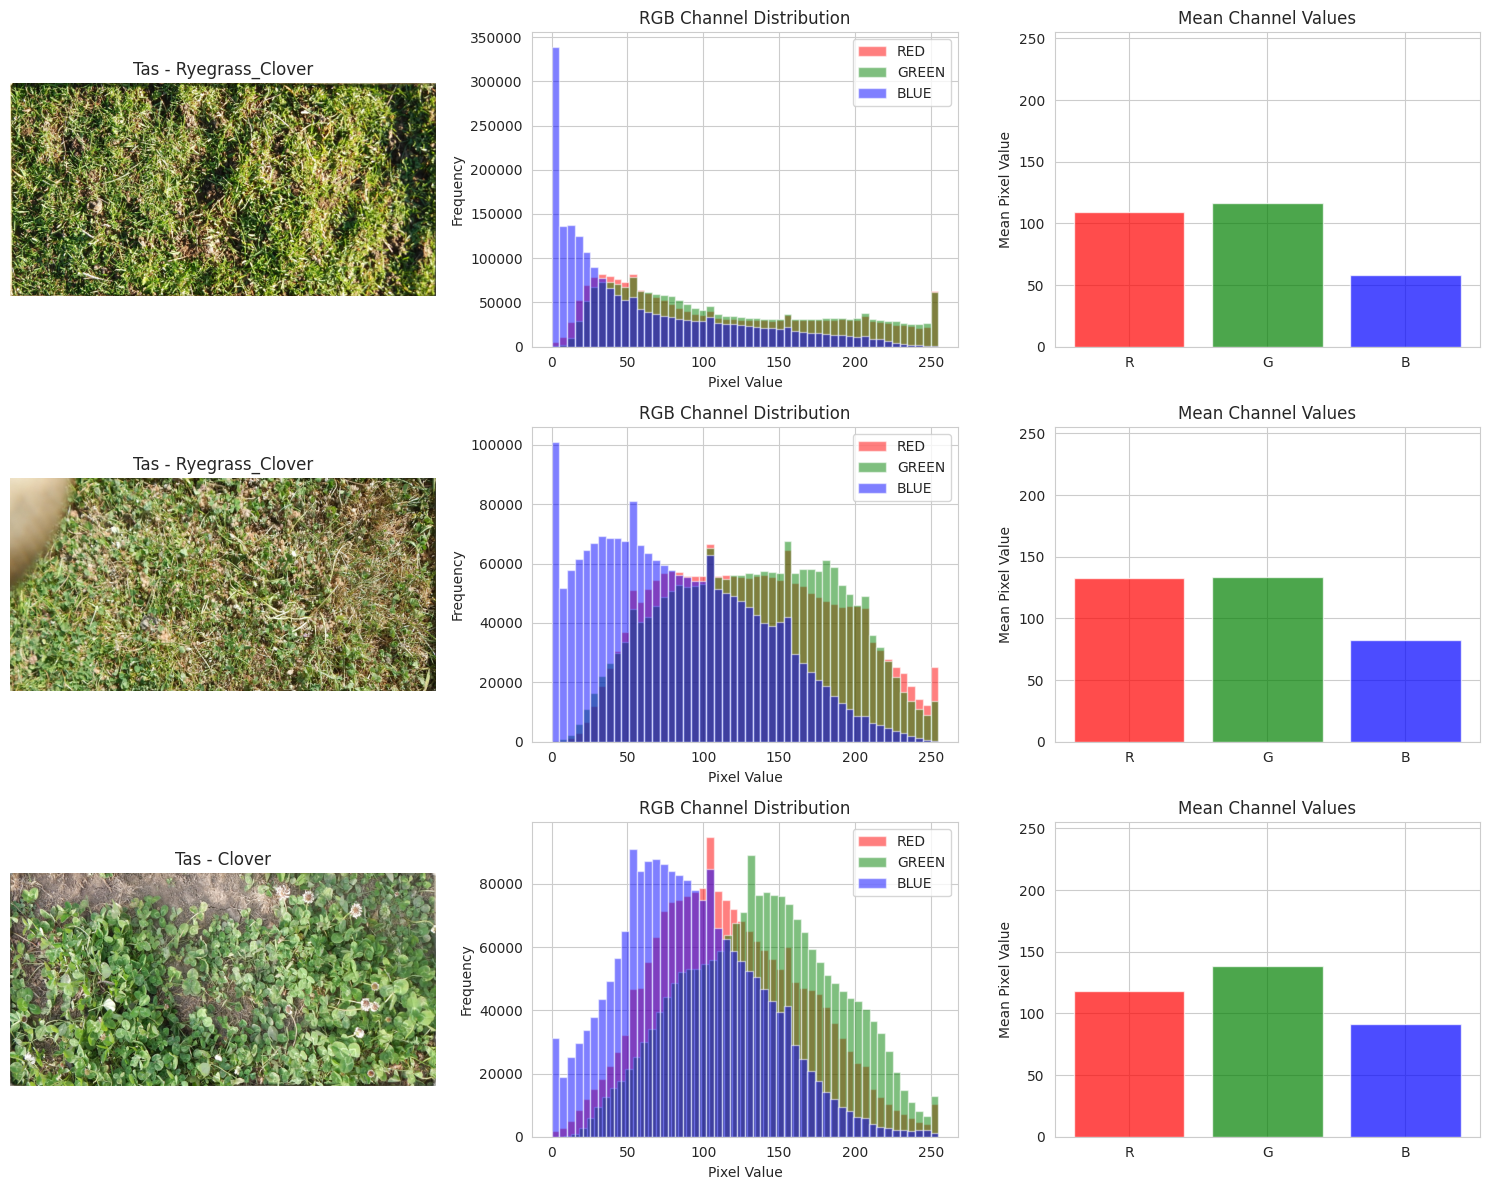

In [24]:
# Analyze RGB channel distributions for a few images
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

sample_images = train_wide.sample(3)

for i, (idx, row) in enumerate(sample_images.iterrows()):
    img_path = BASE_PATH / row['image_path']
    img = np.array(Image.open(img_path))
    
    # Show image
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"{row['State']} - {row['Species'][:20]}")
    
    # RGB histograms
    colors = ['red', 'green', 'blue']
    for c in range(3):
        axes[i, 1].hist(img[:,:,c].flatten(), bins=50, color=colors[c], alpha=0.5, label=colors[c].upper())
    axes[i, 1].set_title('RGB Channel Distribution')
    axes[i, 1].set_xlabel('Pixel Value')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].legend()
    
    # Mean channel values
    mean_vals = [img[:,:,c].mean() for c in range(3)]
    axes[i, 2].bar(['R', 'G', 'B'], mean_vals, color=['red', 'green', 'blue'], alpha=0.7)
    axes[i, 2].set_title('Mean Channel Values')
    axes[i, 2].set_ylabel('Mean Pixel Value')
    axes[i, 2].set_ylim(0, 255)

plt.tight_layout()
plt.show()

## 7. Key Insights Summary

### Data Structure
- 357 training images (2000x1000 px), 1 test image
- Long format: 1,785 rows (357 images x 5 targets)
- No missing values - clean dataset
- Test data lacks metadata features (State, Species, NDVI, Height)

### Target Variables
- **Dry_Clover_g**: 62% have clover present (mean 10.7g when present)
- **Dry_Dead_g**: 89% non-zero (mean 13.6g when present)
- **Dry_Green_g**: 95% non-zero (mean 28.0g when present)
- **Dry_Total_g**: Always present (mean 45.3g, range 1-186g)
- **GDM_g**: Always present (mean 33.3g), equals Dry_Green in only 38% of cases
- **Key constraint**: Dry_Total = Clover + Dead + Green (99.7% exact)

### Geographic and Temporal Patterns
- **States**: Tasmania (138 imgs) > Victoria (112) > NSW (75) > WA (32)
- NSW has highest average biomass (39.7g) and height (20.5 cm)
- Data collected Jan-Sep 2015, most samples in April-May

### Feature Correlations
- Height vs Dry_Total: r = 0.497 (moderate positive)
- NDVI vs Dry_Total: r = 0.361 (weak-moderate positive)
- Metadata features provide some signal but images likely crucial

### Modeling Considerations
1. **Multi-target approach**: Consider shared CNN backbone with 5 output heads
2. **Constraint enforcement**: Can enforce Dry_Total = sum of components
3. **Zero-inflated targets**: Dry_Clover has 38% zeros - may need special handling
4. **Test metadata**: No metadata in test set - model must work from images alone
5. **Image preprocessing**: Consistent 2000x1000 resolution, RGB channels well-distributed
6. **Species/State imbalance**: May need stratified splits or class weighting

### Next Steps
- Build baseline model (e.g., simple CNN or pretrained ResNet)
- Experiment with multi-task learning vs single-task per target
- Consider image augmentation strategies
- Explore metadata as auxiliary input (if available at test time)
- Implement constraint-aware loss function

In [25]:
print("EDA complete! Ready to build models :D")

EDA complete! Ready to build models :D
